In [1]:
# Calculate miu_a, miu_s through x*h=y, x = f(miu_a,miu_s);no deconvolution
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
# import tensorflow as tf
# import tensorflow.keras as keras
import math
# from scipy.optimize import fsolve
# from scipy.optimize import root
from scipy.optimize import minimize
from scipy import signal
from scipy import linalg
# import scipy as scp
# import sympy as  syp
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.models import Sequential
import gc

In [2]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        data=pd.read_fwf(self.path, dtype = object, header = None)## Read data as Pandas DataFrame
        data_8 = data.loc[8,:].str[6:] ## Select data of column of wavelengths

        data_nm_dataframe =pd.read_csv(StringIO(data_8[0]))

        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()

        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 9):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 9):
                break
            else:
                continue

        data_ns = pd.read_csv(StringIO(content[index:len(content)]), names = data_nm_dataframe.columns[0:len(set(data_nm_dataframe))]) ## Read data of time and gray 
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                image as DataFrame; names is a 640x0 array indicates the wavelengths range
        
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        data_846nm = np.zeros((time_total,), dtype = float )
        for i in range(wavelength_total):
            data_846nm = self.data_array[:,i] + data_846nm

        return data_846nm/wavelength_total
    
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array

In [3]:
def name_g(i):
    if(i<=4 and i>=0):
        return  '0'+str(2*i+1)
    elif(i>4):
        return str(2*i+1)
    else:
        return None
    

dict1 = {i:'t5ns_scat'+ name_g(i) +'_abs_00.txt' for i in range(0, 8)}
dict1[-1] = 'ref_real_5ns.txt'


# print(dict1)

scat = [None]*9
data_480multi9 = np.zeros((9,480), dtype = float)
for i in range(0,9):
    scat[i] = process_hyperspec(dict1[i-1], i)
    scat[i].read_data()
    data_480multi9[i,:] = scat[i].cal_846nm()

time_index = scat[0].return_dataframe().index
# plt.figure('ns/nm')
# for i in range(0,1):
#     plt.plot(data_480multi9[i,:])
    
# plt.show()

del scat, dict1, name_g, process_hyperspec
gc.collect()

10

In [4]:
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth



def split_signal(y):
    THRESHOLD_V = 0.02
    for i in range(len(y)):
        if y[i] > THRESHOLD_V and y[i-1] <= THRESHOLD_V:
            index1  = i
        elif y[i] < THRESHOLD_V and y[i-1] >= THRESHOLD_V:
            index2 = i
    y2 = np.zeros((index2 - index1 + 1,))
    y2 = y[index1:index2]
        
    return y2, index1

In [12]:
#Generate h,y(x*h = y)
#===================================================================================================
data_intensity_extended = np.zeros((9, 959), dtype = float)
data_intensity_extended[:, 0:479]  = data_480multi9[:,0:479]
MAX = np.max(data_480multi9)
# h = smooth(data_480multi9[0,:]/max(data_480multi9[0,:]), 10) #x*h = y ; x.shape = (480,) h.shape = (480,) y.shape = (959,)
h = smooth(data_480multi9[0,:]/MAX, 10)

y =np.zeros((9,959))
for i in range(0,9):
    y[i,:] = smooth(data_intensity_extended[i,:]/max(data_intensity_extended[i,:]), 10)
    
#======================================================================================================

In [6]:
class calculate_miu_s(object):
    
    def __init__(self, h, y, time_index):
        self.h = h
        self.y = y
        self.time = time_index
        return None
    
    def transmittance(self, d, t, c, g, miu_a, miu_s):
        miu_s_prime = (1-g)*miu_s
        Z0 = 1/(miu_s_prime)
        D = 1/(3*(miu_a + miu_s_prime))
        h1 = math.pow(4*math.pi*D*c, -0.5)
        h2 = math.pow(t, -1.5)*math.exp(-miu_a*c*t)
        h3 = (d-Z0)*math.exp(-(math.pow(d-Z0, 2))/(4*D*c*t))
        h4 = (d+Z0)*math.exp(-(math.pow(d+Z0, 2))/(4*D*c*t))
        h5 = (3*d-Z0)*math.exp(-(math.pow(3*d-Z0, 2))/(4*D*c*t))
        h6 = (3*d+Z0)*math.exp(-(math.pow(3*d+Z0, 2))/(4*D*c*t))
    #     return d,Z0,D,c,t
        return h1*h2*(h3-h4+h5-h6)
    
    
    def error_cal(self, x):
        miu_s = x[0]
        # miu_a = x[1]
        miu_a = 0.01e2
        g = 0.7
        d = 0.01
        # t = 300e-12
        c = 3e8/1.3314
        T = int(480)
#         time = np.array(range(1,T, 1))
#         time = time*1e-8*0.010345058455114822
        time = self.time*1e-9
        miu_s = miu_s*1e4
        intensity1 = np.zeros((T, ), dtype = float)
        for i in range(time.shape[0] - 1):

            intensity1[i] = calculate_miu_s.transmittance(self, d, time[i], c, g, miu_a, miu_s)
        
        y2 = np.convolve(intensity1, self.h)
        self.intensity = intensity1
        self.y_convolved = y2
        y2 = y2/max(y2)
        return np.sum(abs(y2-self.y))
#         return time

    def get_convolved_signal(self):
        return self.y_convolved
        
    def get_x(self):
        return self.intensity

In [32]:
rr = calculate_miu_s(h, y[5,:], time_index)
minimize(rr.error_cal, x0 = [0.1, 0.1], method  = 'Nelder-Mead', options={"xtol" : 1e-10, "disp":True})

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_18408/2268199636.py:43: RuntimeWarning: divide by zero encountered in true_divide
  y2 = y2/max(y2)
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_18408/2268199636.py:43: RuntimeWarning: invalid value encountered in true_divide
  y2 = y2/max(y2)


 final_simplex: (array([[3.33333335e-02, 2.34874099e+02],
       [3.33333335e-02, 2.33528934e+02],
       [3.33333335e-02, 2.33908989e+02]]), array([26.79340747, 26.80417828, 26.81156378]))
           fun: 26.793407472201267
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 401
           nit: 214
        status: 1
       success: False
             x: array([3.33333335e-02, 2.34874099e+02])

In [14]:
miu_s_get = np.zeros((8,2))
m = [None]*8
for i in range(1,9):
    m[i-1] = calculate_miu_s(h, y[i], time_index)
    miu_s_get[i-1,:] = minimize(m[i-1].error_cal, x0 = [0.6], method  = 'Nelder-Mead', options={"xtol" : 1e-20, "disp":True}).x

Optimization terminated successfully.
         Current function value: 8.482568
         Iterations: 58
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 4.427389
         Iterations: 67
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 5.761745
         Iterations: 52
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 9.096595
         Iterations: 65
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 14.444736
         Iterations: 62
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 20.341063
         Iterations: 58
         Function evaluations: 122
Optimization terminated successfully.
         Current function value: 27.045430
         Iterations: 57
         Function evaluations: 122


In [15]:
miu_s_get

array([[0.24549146, 0.24549146],
       [0.46360175, 0.46360175],
       [0.67201869, 0.67201869],
       [0.90630461, 0.90630461],
       [1.17425462, 1.17425462],
       [1.38990372, 1.38990372],
       [1.56551345, 1.56551345],
       [1.7578158 , 1.7578158 ]])

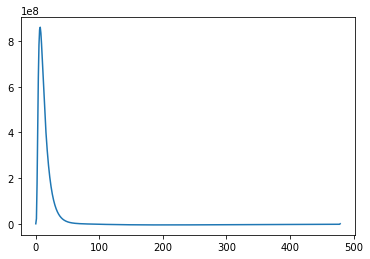

In [39]:
m = [None]*8
plt.figure()
for i in range(0,1):
    m[i] = calculate_miu_s(h, y[i,:], time_index)
    m[i].error_cal(miu_s_get[i])
    plt.plot(m[i].get_x()[0:480])

# m2.error_cal(x = [1.32009632, 0.83100736])
# plt.plot(m2.get_convolved_signal())

# m2.error_cal(x = [1.35795134, 0.37235146])

# plt.plot(m2.get_convolved_signal())
plt.show()
# print(y2.shape,y.shape)

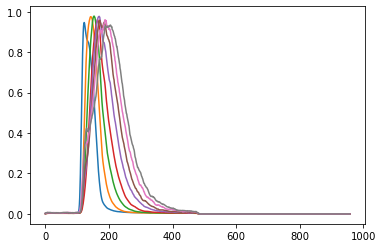

In [13]:
for i in range(1,9):
    plt.plot(y[i,:])
    
plt.show()

In [35]:
miu_s_get = np.array([[0.24,0.64],[0.56,0.91],[0.85,0.81],[1.24,0.79],[1.27,0.31],[1.51,0.30],[1.76,0.29],[2.44,0.51]])

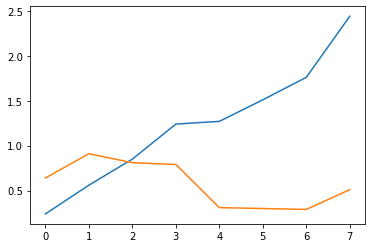

In [36]:
plt.figure()
plt.plot(miu_s_get[:,0])
plt.plot(miu_s_get[:,1])
plt.show()